In [11]:
from jsonschema.exceptions import best_match
from torchvision.datasets import MNIST, CIFAR10
from mynn.data import mnist_augment, preprocess, basic_mnist_augment, merge_datasets, cifar10_augment, basic_cifar10_augment
from mynn.layer import Flatten, Linear, ReLU, He, Conv, Dropout, Pooling, BN
from mynn.layer.blocks import BasicBlock
from mynn.loss import CrossEntropy
from mynn import Model
from mynn.optimizer import SGD, Adam, MomentGD
from mynn.runner import RunnerM, EarlyStopping, CosineAnnealingLR
import cupy as cp

In [12]:
cp.random.seed(42)


# 1. 数据加载与预处理
train_dataset = CIFAR10(
    root="../cifar10",
    train=True,
    transform=basic_cifar10_augment(train=True),
    download=False
)
test_dataset = CIFAR10(
    root="../cifar10",
    train=False,
    transform=basic_cifar10_augment(train=False),
    download=False
)




In [13]:
train_images, train_labels = preprocess(train_dataset)
test_images,  test_labels  = preprocess(test_dataset)

train_set = (train_images[:45000], train_labels[:45000])
dev_set   = (train_images[45000:], train_labels[45000:])
test_set  = (test_images,       test_labels)

# # 数据增强
# train_dataset_augment = CIFAR10(
#     root="../cifar10",
#     train=True,
#     transform=cifar10_augment(train=True),
#     download=False
# )

# train_images, train_labels = preprocess(train_dataset_augment)
# train_set_augment = (train_images[:45000], train_labels[:45000])
# dev_set_augment   = (train_images[45000:], train_labels[45000:])
# 
# train_set = merge_datasets(train_set, train_set_augment)
# dev_set = merge_datasets(dev_set, dev_set_augment)






In [14]:
import numpy as np

print("Min pixel value:", np.min(test_images))
print("Max pixel value:", np.max(test_images))

Min pixel value: 0.0
Max pixel value: 1.0


In [20]:
weight_decay_val = 0.001

layers = [
    Conv(in_channel=3, out_channel=64, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 64, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=64, out_channel=128, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 128, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=128, out_channel=256, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 256, 1, 1)),
    ReLU(),

    Conv(in_channel=256, out_channel=256, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 256, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=256, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Pooling(kernel=2),

    Flatten(),
    Linear(in_channel=512 * 1 * 1, out_channel=512, weight_decay=0.001),
    ReLU(),
    Linear(in_channel=512, out_channel=512, weight_decay=0.001),
    ReLU(),
    Linear(in_channel=512, out_channel=10, weight_decay=0.001)
]



In [21]:
model     = Model(layers)
optimizer = Adam(model=model, lr=0.001)
# optimizer = SGD(model=model, lr=0.001)
# optimizer = MomentGD(model=model, lr=0.001)
loss_fn   = CrossEntropy(model=model)
runner    = RunnerM(model=model, loss=loss_fn, optimizer=optimizer)

Epoch 1/20: 100%|██████████| 352/352 [04:51<00:00,  1.21batch/s, accuracy=0.625, loss=1.09] 
train_loss: 0.85748, train_acc: 0.69968
dev_loss  : 0.92475, dev_acc  : 0.67471
### Best model saved to: best_model\2025-05-20_19-05-19\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.67471
Patience Counter Reset to 0

Epoch 2/20: 100%|██████████| 352/352 [04:59<00:00,  1.18batch/s, accuracy=0.736, loss=0.765]
train_loss: 0.64168, train_acc: 0.77858
dev_loss  : 0.82344, dev_acc  : 0.70824
### Best model saved to: best_model\2025-05-20_19-05-19\best_model.pickle
### Best validation accuracy updated: 0.67471 -> 0.70824
Patience Counter Reset to 0

Epoch 3/20: 100%|██████████| 352/352 [04:49<00:00,  1.21batch/s, accuracy=0.819, loss=0.526]
train_loss: 0.46678, train_acc: 0.84111
dev_loss  : 0.74415, dev_acc  : 0.74827
### Best model saved to: best_model\2025-05-20_19-05-19\best_model.pickle
### Best validation accuracy updated: 0.70824 -> 0.74827
Patience Counter Reset to 0

E

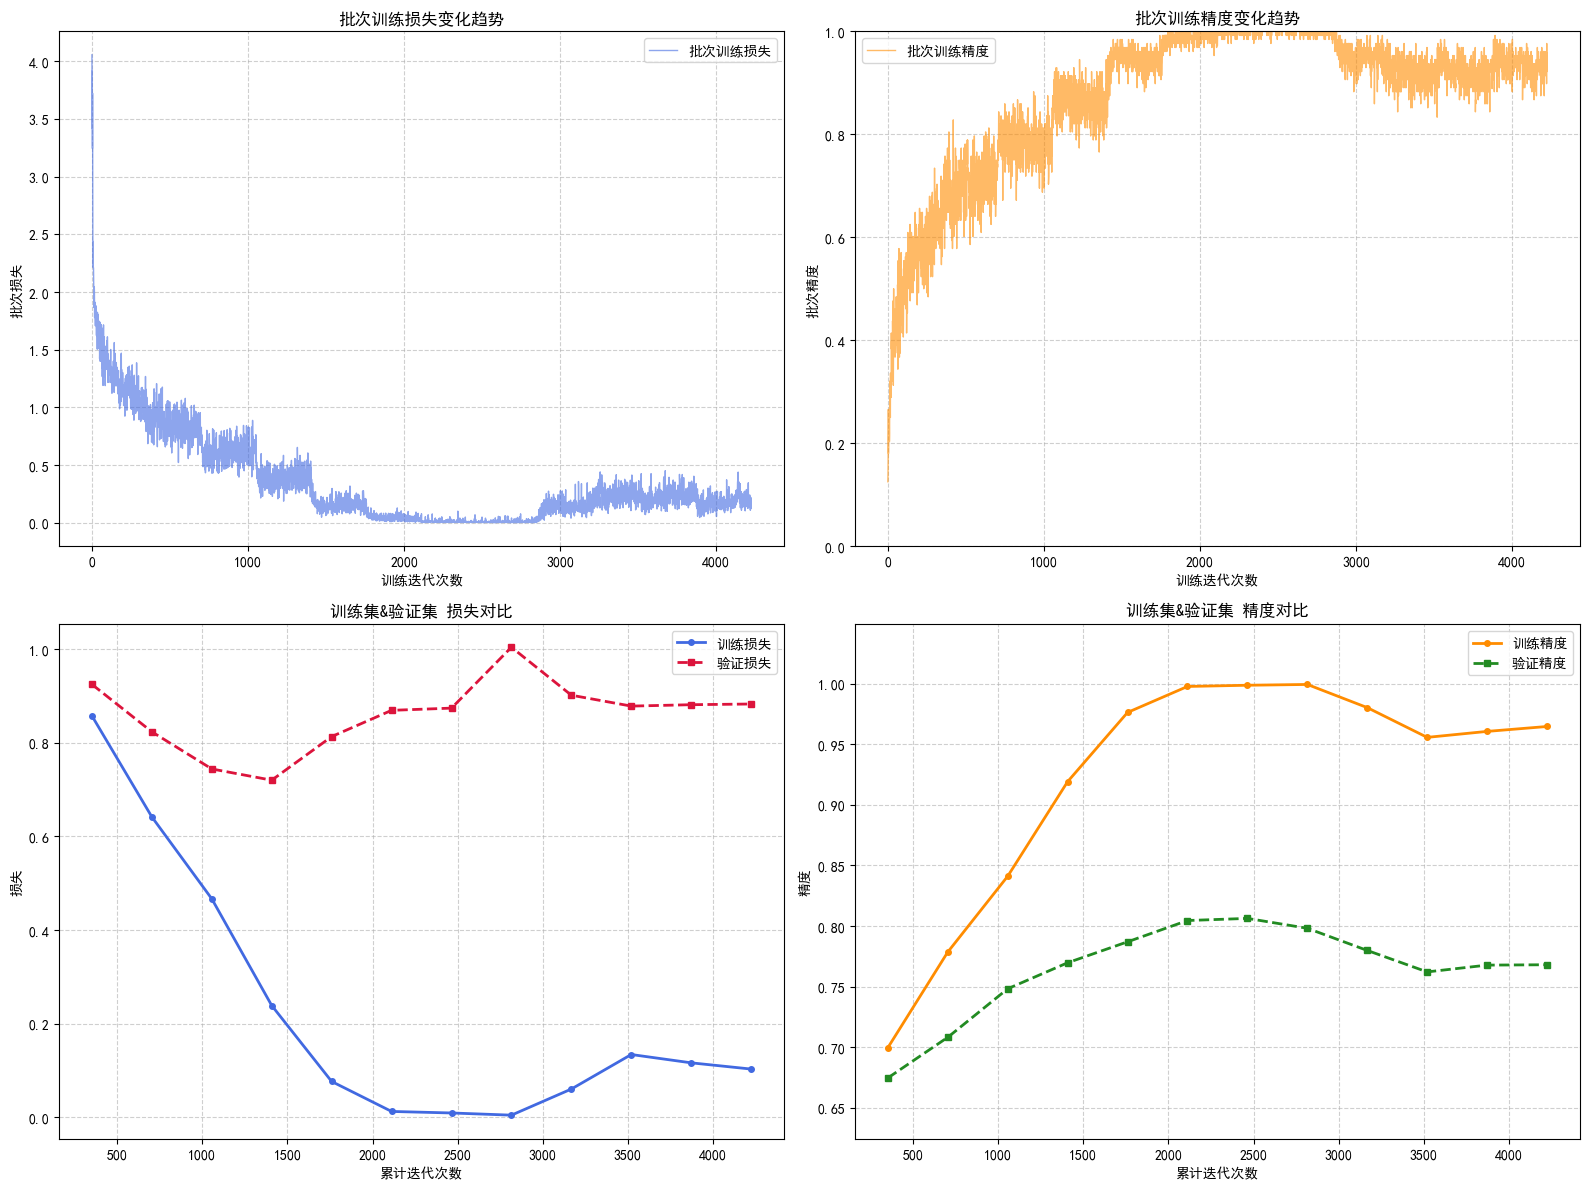

In [22]:
# 3. 训练
runner.train(
    train_set=train_set,
    dev_set=dev_set,
    batch_size=128,
    num_epochs=20,
    scheduler=CosineAnnealingLR(
        optimizer=optimizer,
        T_max=5,
        eta_min=1e-5,
    ),
    strategy=EarlyStopping(
        patience=5,
        delta=0,
    ),
    shuffle=True,
    save_dir='best_model_basic',
)


In [23]:
# 4. 测试集评估
test_loss, test_acc = runner.evaluate(test_set, batch_size=128,loss_fn=loss_fn)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.98508, Test accuracy: 0.75138


In [24]:
from mynn.attack import fgsm_attack
adv_test_images = fgsm_attack(
    model=model, 
    images=test_images, 
    labels=test_labels, 
    loss_fn=loss_fn,
    epsilon=1/255.0  
)

test_set_adv = (adv_test_images, test_labels)

KeyboardInterrupt: 

In [ ]:
print("Min pixel value:", np.min(adv_test_images))
print("Max pixel value:", np.max(adv_test_images))

In [ ]:
adv_loss, adv_acc = runner.evaluate(test_set_adv, batch_size=64,loss_fn=loss_fn)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

In [ ]:
import matplotlib.pyplot as plt
def plot_images(images, labels, title=""):
    """
    显示前五张图片，自动处理 Cupy/NumPy、范围归一化等
    - images: (N, C, H, W)，可为 Cupy 或 NumPy
    - labels: (N,) 或 (N, C)
    """
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)

    for i in range(5):
        ax = axes[i]

        # 取单张图片，并转 (H, W, C)
        img = images[i].transpose(1, 2, 0)

        # 如果是 cupy，则转为 numpy
        if hasattr(img, 'get'):
            img = img.get()

        # 如果像素最大值超过1，说明是 [0, 255]，就归一化
        if img.max() > 1:
            img = img / 255.0

        img = np.clip(img, 0, 1)  # 保险剪裁，防止 overflow

        ax.imshow(img)
        # 标签显示
        label = labels[i]
        label_text = np.argmax(label) if len(label.shape) > 0 and label.shape[0] > 1 else label
        ax.set_title(f"Label: {label_text}")
        ax.axis('off')

    plt.show()

In [ ]:
print("Displaying original images...")
plot_images(test_images, test_labels, title="First 5 Images from Test Set")

print("Displaying adversarial images...")
plot_images(adv_test_images, test_labels, title="First 5 Adversarial Images")

In [29]:
weight_decay_val = 0.001

layers2 = [
    Conv(in_channel=3, out_channel=64, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 64, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=64, out_channel=128, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 128, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=128, out_channel=256, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 256, 1, 1)),
    ReLU(),

    Conv(in_channel=256, out_channel=256, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 256, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=256, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Pooling(kernel=2),


    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Conv(in_channel=512, out_channel=512, kernel=3, stride=1, padding=1, weight_decay=0.001),
    BN(normalized_dims=(0, 2, 3), param_shape=(1, 512, 1, 1)),
    ReLU(),

    Pooling(kernel=2),

    Flatten(),
    Linear(in_channel=512 * 1 * 1, out_channel=512, weight_decay=0.001),
    ReLU(),
    Linear(in_channel=512, out_channel=512, weight_decay=0.001),
    ReLU(),
    Linear(in_channel=512, out_channel=10, weight_decay=0.001)
]


In [30]:
model2 = Model(layers2)
optimizer2 = Adam(model=model2, lr=0.001)
loss_fn2  = CrossEntropy(model=model2)
runner2  = RunnerM(model=model2, loss=loss_fn2, optimizer=optimizer2)

[Adversarial Train] Epoch 1/15: 100%|██████████| 352/352 [07:26<00:00,  1.27s/batch, accuracy=0.611, loss=1.13]
train_loss: 1.09765, train_acc: 0.60163
dev_loss  : 1.12706, dev_acc  : 0.58798
### Best model saved to: best_models\2025-05-20_20-32-28\best_model.pickle
### Best validation accuracy updated: 0.00000 -> 0.58798
Patience Counter Reset to 0

[Adversarial Train] Epoch 2/15: 100%|██████████| 352/352 [07:32<00:00,  1.29s/batch, accuracy=0.639, loss=1.03] 
train_loss: 0.84077, train_acc: 0.69970
dev_loss  : 0.91201, dev_acc  : 0.67911
### Best model saved to: best_models\2025-05-20_20-32-28\best_model.pickle
### Best validation accuracy updated: 0.58798 -> 0.67911
Patience Counter Reset to 0

[Adversarial Train] Epoch 3/15: 100%|██████████| 352/352 [07:48<00:00,  1.33s/batch, accuracy=0.667, loss=0.888]
train_loss: 0.58545, train_acc: 0.80511
dev_loss  : 0.74345, dev_acc  : 0.73786
### Best model saved to: best_models\2025-05-20_20-32-28\best_model.pickle
### Best validation accur

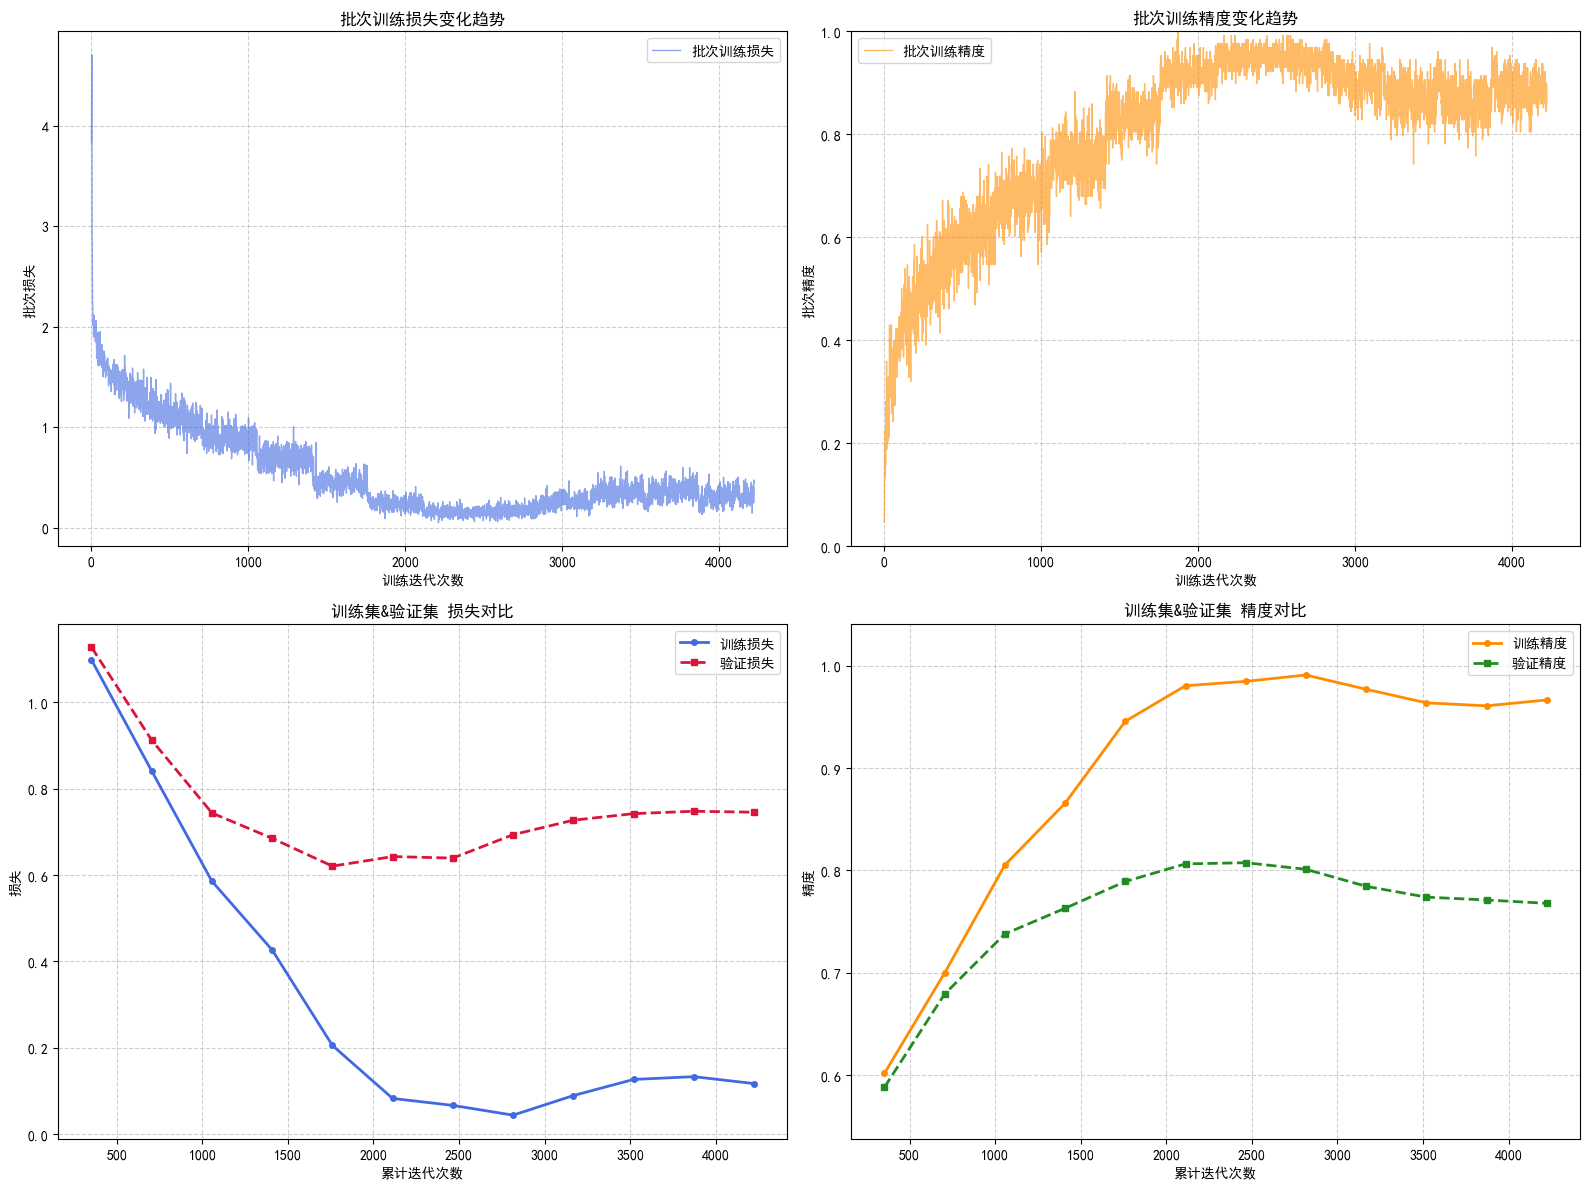

In [31]:
runner2.train_with_attack(
        train_set=train_set,
        dev_set=dev_set,
        batch_size=128,
        num_epochs=15,
        scheduler=CosineAnnealingLR(
            optimizer=optimizer2,
            T_max=5,
            eta_min=1e-5,
        ),
        strategy=EarlyStopping(
            patience=5,
            delta=0.0,
        ),
        shuffle=True,
        save_dir='best_models'
    )

In [32]:
test_loss, test_acc = runner2.evaluate(test_set, batch_size=64,loss_fn=loss_fn2)
print(f"Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.5f}")

Test loss: 0.82704, Test accuracy: 0.74821


In [33]:
from mynn.attack import fgsm_attack
adv_test_images = fgsm_attack(
    model=model2,
    images=test_images,
    labels=test_labels,
    loss_fn=loss_fn2,
    epsilon=1/255
)

test_set_adv = (adv_test_images, test_labels)
adv_loss, adv_acc = runner2.evaluate(test_set_adv, batch_size=64,loss_fn=loss_fn2)
print(f"Adversarial Test loss: {adv_loss:.5f}, Test accuracy: {adv_acc:.5f}")

Adversarial Test loss: 1.44030, Test accuracy: 0.61236
